# Proof of Concept: Linking Climate Data with CFD Prices for Agricultural Commodities

**Objective:** Evaluate the feasibility of predicting CFD price movements (e.g., cotton) by incorporating monthly (or daily aggregated) climatic data over the last 20 years. This notebook serves as a preliminary investigation using machine learning techniques and exploratory data analysis.

**Outline:**
1. Data Acquisition and Loading
2. Data Preprocessing and Aggregation
3. Exploratory Data Analysis (EDA)
4. Feature Engineering (including creation of climatic indices and lag variables)
5. Modeling: Training a simple ML model (e.g., RandomForest)
6. Model Evaluation and Interpretation
7. Conclusions and Next Steps


## 1. Importing Libraries
Import necessary libraries for data analysis, visualization, and modeling.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# You can add more libraries as needed

%matplotlib inline

## 2. Data Acquisition and Loading
Load the climate and CFD price data. For this PoC, you can use synthetic datasets or CSV samples.

*Example files:*
- `climate_data.csv`: Daily or monthly climate variables (temperature, precipitation, extreme events, etc.)
- `price_data.csv`: Historical CFD price series (e.g., cotton) on a monthly basis

In [4]:
import xarray as xr
ds=xr.open_dataset("/Users/charly_1/Downloads/22491997/CROPGRIDSv1.08_NC_maps/CROPGRIDSv1.08_cocoa.nc")

ValueError: No matching item found for the query 'naturalearth_lowres'.

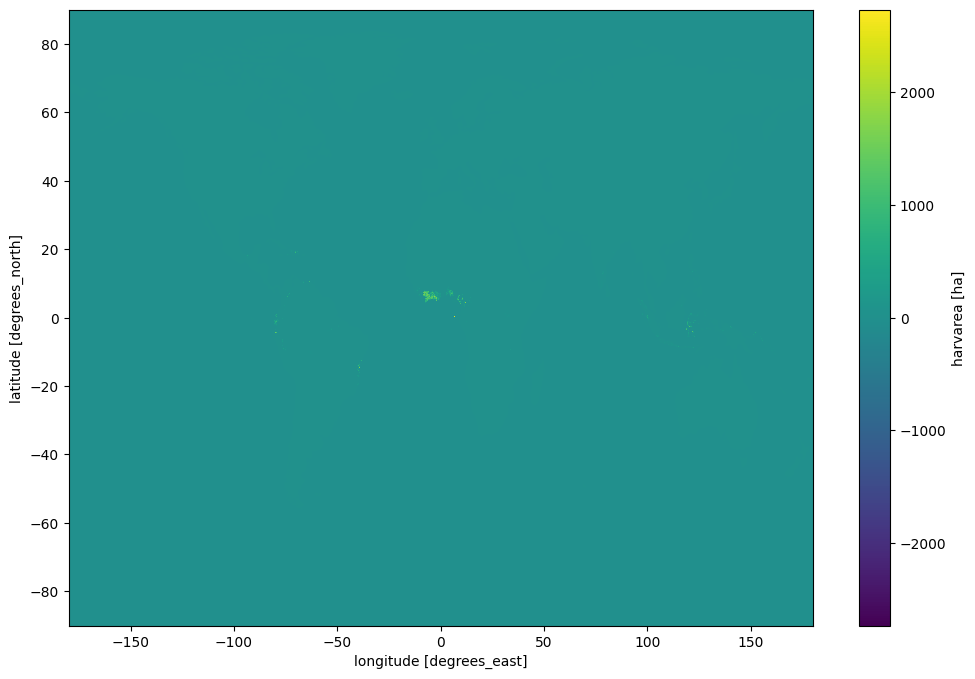

In [ ]:
import geopandas as gpd
from geodatasets import get_path

ax = ds["harvarea"].plot(figsize=(12, 8), cmap='viridis')
world = gpd.read_file(get_path('naturalearth_lowres'))
world.boundary.plot(ax=ax, edgecolor='black', linewidth=1)
ax.set_title("Harvarea overlayed on World Countries")
plt.show()


In [ ]:
# Importa la función para descargar y extraer archivos desde el módulo de utilidades
from src.utilities.download_utilities import download_and_extract_archive

# Importaciones estándar para gestionar la descarga y procesamiento
import os
import cdsapi
from pathlib import Path
import logging
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# Configuración básica del logger (opcional)
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Definir manualmente las credenciales de CDS API
cdsapi_url="https://cds.climate.copernicus.eu/api/"
cdsapi_key="<REMOVED_CDSAPI_KEY>"

# Escribir la configuración en el archivo .cdsapirc
cdsapirc_path = Path.home() / ".cdsapirc"
with open(cdsapirc_path, "w") as f:
    f.write(f"url: {cdsapi_url}\n")
    f.write(f"key: {cdsapi_key}\n")

# Definir el dataset y la solicitud para obtener la temperatura máxima diaria
dataset = "derived-era5-single-levels-daily-statistics"
request = {
    "product_type": "reanalysis",
    "variable": ["2m_temperature"],
    "year": "2010",
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "day": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12",
        "13", "14", "15",
        "16", "17", "18",
        "19", "20", "21",
        "22", "23", "24",
        "25", "26", "27",
        "28", "29", "30",
        "31"
    ],
    "daily_statistic": "daily_maximum",
    "time_zone": "utc+00:00",
    "frequency": "1_hourly"
}


# Crear el cliente CDS API (se leerán las credenciales de .cdsapirc)
client = cdsapi.Client()

# Definir el directorio de salida
output_dir = Path("/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs")
output_dir.mkdir(parents=True, exist_ok=True)

# Definir el nombre del archivo de salida para la temperatura
output_file = output_dir / "era5_land_temp_2020_01.nc"

# Ejecutar la solicitud y descargar el archivo
client.retrieve(dataset, request).download(str(output_file))

2025-03-09 13:49:06,575 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-09 13:49:06,575 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-03-09 13:49:07,065 WARNING [2025-02-12T00:00:00] Requests for non-consecutive date ranges combined with non-UTC time-zones may contain undersampled data points for the dates before and after the gap in the date range. See known-issues table on documentation tab for more details.
2025-03-09 13:49:07,065 INFO Request ID is 3bc4f65e-bcd8-448d-a370-f63feb672c06
INFO:datapi.legacy_api_client:Request ID

In [ ]:
# Importa la función para descargar y extraer archivos desde el módulo de utilidades
from src.utilities.download_utilities import download_and_extract_archive

# Importaciones estándar para gestionar la descarga y procesamiento
import os
import cdsapi
from pathlib import Path
import logging
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

# Configuración básica del logger (opcional)
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Definir manualmente las credenciales de CDS API
cdsapi_url="https://cds.climate.copernicus.eu/api/"
cdsapi_key="<REMOVED_CDSAPI_KEY>"

# Escribir la configuración en el archivo .cdsapirc
cdsapirc_path = Path.home() / ".cdsapirc"
with open(cdsapirc_path, "w") as f:
    f.write(f"url: {cdsapi_url}\n")
    f.write(f"key: {cdsapi_key}\n")

# Definir el dataset y la solicitud para obtener la temperatura máxima diaria
dataset = "derived-era5-single-levels-daily-statistics"
request = {
    "product_type": "reanalysis",
    "variable": ["total_precipitation"],
    "year": "2010",
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "day": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12",
        "13", "14", "15",
        "16", "17", "18",
        "19", "20", "21",
        "22", "23", "24",
        "25", "26", "27",
        "28", "29", "30",
        "31"
    ],
    "daily_statistic": "daily_sum",
    "time_zone": "utc+00:00",
    "frequency": "1_hourly"
}


# Crear el cliente CDS API (se leerán las credenciales de .cdsapirc)
client = cdsapi.Client()

# Definir el directorio de salida
output_dir = Path("/Users/charly_1/Documents/GitHub/crop_analysis/data_inputs")
output_dir.mkdir(parents=True, exist_ok=True)

# Definir el nombre del archivo de salida para la temperatura
output_file = output_dir / "era5_land_prep_2020_01.nc"

# Ejecutar la solicitud y descargar el archivo
client.retrieve(dataset, request).download(str(output_file))

2025-03-09 13:17:23,313 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-09 13:17:23,314 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.


HTTPError: 403 Client Error: Forbidden for url: https://cds.climate.copernicus.eu/api//retrieve/v1/processes/derived-era5-single-levels-daily-statistics/execution
cost limits exceeded
Your request is too large, please reduce your selection.

# Vulnerability Function for Cocoa Yield Loss

This section implements a vulnerability function that estimates the percentage yield loss for cocoa based on daily maximum temperature and monthly precipitation. The function is defined as follows:

\[
L(T, P) = 100 \times \left(1 - \exp\left[-\alpha \cdot \max(0, T - T_{\text{opt}})\right]\right) + \beta \cdot \max(0, P_{\text{th}} - P)
\]

where:
- \(T\) is the daily maximum temperature in degrees Celsius.
- \(T_{\text{opt}}\) is the optimum temperature for cocoa (assumed here as 24 °C).
- \(\alpha\) is the temperature sensitivity coefficient (default value 0.11).
- \(P\) is the monthly precipitation in mm.
- \(P_{\text{th}}\) is the critical precipitation threshold (assumed 100 mm).
- \(\beta\) is the precipitation deficit coefficient (default value 0.0075 per mm).

This function is inspired by quantitative approaches found in the literature, such as the studies by [Schroth et al., 2016](http://dx.doi.org/10.1016/j.scitotenv.2016.03.024) and [Läderach et al., 2013](http://dx.doi.org/10.1007/s10584-013-0774-8), which relate climate hazards (e.g., excessive temperature and rainfall deficits) to changes in the climatic suitability for cocoa. In our formulation, the yield loss increases exponentially when the temperature exceeds the optimum and linearly when precipitation falls below the threshold.

Below is the Python code that defines and demonstrates the usage of this vulnerability function.

In [10]:
import numpy as np

def vulnerability_loss(T, P, T_opt=24.0, P_th=100.0, alpha=0.11, beta=0.0075):
    """
    Compute the estimated yield loss percentage for cocoa based on daily maximum temperature (T) 
    and monthly precipitation (P).
    
    Parameters:
    - T (float): Daily maximum temperature (°C).
    - P (float): Monthly total precipitation (mm).
    - T_opt (float): Optimum temperature for cocoa (default 24°C).
    - P_th (float): Critical precipitation threshold (default 100 mm).
    - alpha (float): Temperature sensitivity coefficient (default 0.11).
    - beta (float): Precipitation deficit coefficient (default 0.0075 per mm deficit).
    
    Returns:
    - float: Estimated yield loss percentage.
    
    The function is defined as:
    
    L(T, P) = 100 * (1 - exp[-alpha * max(0, T - T_opt)]) + beta * max(0, P_th - P)
    """
    temp_excess = max(0, T - T_opt)
    temp_effect = 100 * (1 - np.exp(-alpha * temp_excess))
    precip_deficit = max(0, P_th - P)
    precip_effect = beta * precip_deficit
    return temp_effect + precip_effect

# Example usage:
T_example = 26  # Daily maximum temperature in °C (2°C above the optimum)
P_example = 80  # Monthly precipitation in mm (20 mm below the threshold)
loss_percentage = vulnerability_loss(T_example, P_example)
print(f"Estimated yield loss percentage: {loss_percentage:.2f}%")

Estimated yield loss percentage: 19.90%


## 3. Data Preprocessing and Aggregation
Convert the date columns to datetime (if not already done), handle missing values and outliers, aggregate daily data into monthly metrics (e.g., averages, sums, or counts of extreme events), and merge both datasets using the `date` column.

In [ ]:
# Example: Aggregating daily climate data to monthly data
climate_monthly = climate_df.resample('M', on='date').agg({
    'temperature': 'mean',
    'precipitation': 'sum',
    # Assuming 'hail' is a binary indicator, count the number of days with hail events
    'hail': 'sum'
}).reset_index()

# Merge climate and price data
data = pd.merge(price_df, climate_monthly, on='date', how='inner')

## 4. Exploratory Data Analysis (EDA)
Visualize the time series, examine variable distributions, and compute a correlation matrix to identify preliminary relationships.

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['price'], label='CFD Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('CFD Price Over Time')
plt.legend()
plt.show()

# Calculate and print the correlation matrix
corr_matrix = data.corr()
print(corr_matrix)

## 5. Feature Engineering
Create new features such as drought indices, counts of extreme events, or lag variables. For example, create a one-month lag for precipitation.

In [ ]:
data['precipitation_lag1'] = data['precipitation'].shift(1)
# Remove rows with NA values resulting from the shift
data = data.dropna()

## 6. Modeling: Training a Simple Machine Learning Model
Use a simple model (e.g., RandomForest) to predict the CFD price using the climate variables as predictors.

In [ ]:
# Define features and target
features = ['temperature', 'precipitation', 'hail', 'precipitation_lag1']
target = 'price'

# Use TimeSeriesSplit for temporal cross-validation
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(data):
    train_data, test_data = data.iloc[train_index], data.iloc[test_index]
    
    X_train = train_data[features]
    y_train = train_data[target]
    X_test = test_data[features]
    y_test = test_data[target]
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    print(f'RMSE: {rmse:.2f}, MAE: {mae:.2f}')

## 7. Model Evaluation and Interpretation
Visualize the predictions versus the actual values and analyze feature importance to understand the impact of each climate variable.

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test_data['date'], y_test, label='Actual Price')
plt.plot(test_data['date'], predictions, label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs Predicted CFD Prices')
plt.legend()
plt.show()

# Display feature importances
importances = model.feature_importances_
for feat, imp in zip(features, importances):
    print(f'{feat}: {imp:.2f}')

## 8. Conclusion and Next Steps
Summarize your findings and the model's predictive capability. Discuss limitations and potential improvements (e.g., incorporating more climatic variables, using hybrid models or LSTM networks). Outline the next steps to transition this PoC into a production-level model, such as integrating streaming data and continuously updating the model.

# End of Notebook

This PoC serves as a starting point to evaluate whether incorporating climate data can improve the prediction of agricultural CFD prices. Further research and model refinement will be necessary to address challenges such as data granularity, external economic factors, and model adaptability over time.